<br>

**Herein**, a varying intercept & varying gradient stochastic regression model wherein the dependent variables are modelled as covarying series.

<br>

# Preliminaries

Cleaning-up

In [1]:
!rm -rf *.sh

<br>

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/sars/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Paths**

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)


In [6]:
warehouse = 'natural'

if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

**Libraries**

In [7]:
%matplotlib inline

In [8]:
import arviz as az
import graphviz
import pymc3 as pm

import logging
import collections

import numpy as np
import pandas as pd
import scipy as sp
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano


<br>

Custom

In [9]:
import sars.graphics.settings
import sars.graphics.relational

<br>

**Generic Instances**

In [10]:
relational = sars.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

## Set-up

**Display**<br>
If the display screen supports **retina display**, a figure's resolution can be enhanced via


In [11]:
%config InlineBackend.figure_format = 'retina'

<br>

**Jupyter Settings**

In [12]:
settings = sars.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

## Logging

In [13]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Baseline

In [14]:
import sars.models.inpatients.src.baseline

In [15]:
baseline = sars.models.inpatients.src.baseline.Baseline().exc()

In [16]:
baseline.rename(columns={"datetimeobject": "date"}, inplace=True)

In [17]:
logger.info('\n{}\n'.format(baseline.tail()))

INFO:__main__:
            date STUSPS  deathCumulative  positiveCumulative  \
12390 2021-02-02     WY            624.0             52128.0   
12391 2021-02-03     WY            624.0             52288.0   
12392 2021-02-04     WY            624.0             52468.0   
12393 2021-02-05     WY            624.0             52576.0   
12394 2021-02-06     WY            624.0             52618.0   

       hospitalizedCumulative   deathRate  positiveRate  hospitalizedRate  \
12390                  1289.0  107.816898   9006.857777        222.717919   
12391                  1293.0  107.816898   9034.503135        223.409053   
12392                  1300.0  107.816898   9065.604163        224.618537   
12393                  1302.0  107.816898   9084.264780        224.964104   
12394                  1303.0  107.816898   9091.521687        225.136888   

       ndays  
12390    330  
12391    331  
12392    332  
12393    333  
12394    334  



<br>
<br>

## Focus

In [18]:
Futures = collections.namedtuple(typename='Futures', field_names=['steps', 'ahead'])
futures = Futures._make([np.array([1]), 21])

In [19]:
Variables = collections.namedtuple(typename='Variables', field_names=['independent', 'dependent', 'label', 'independent_'])
variables = Variables._make((['ndays'], ['positiveCumulative', 'hospitalizedCumulative', 'deathCumulative'], 
                             ['positives [C]', 'hospitalized [C]', 'deaths [C]'], 'date'))

<br>

**State**

In [20]:
stusps = 'ND'

<br>

**Data**

* N: The number of records
* M: The number of independent variables
* P: The number of dependent variables

In [21]:
import sars.models.inpatients.src.focus

In [22]:
data, parameters = sars.models.inpatients.src.focus.Focus(
    baseline=baseline, variables=variables, futures=futures).exc(stusps=stusps)

logger.info('The fields of data\n{}\n'.format(data._fields))
logger.info('The fields of parameters\n{}\n'.format(parameters._fields))

INFO:__main__:The fields of data
('abscissae', 'independent', 'dependent', 'abscissae_', 'independent_')

INFO:__main__:The fields of parameters
('N', 'M', 'P')



<br>

**Illustration**

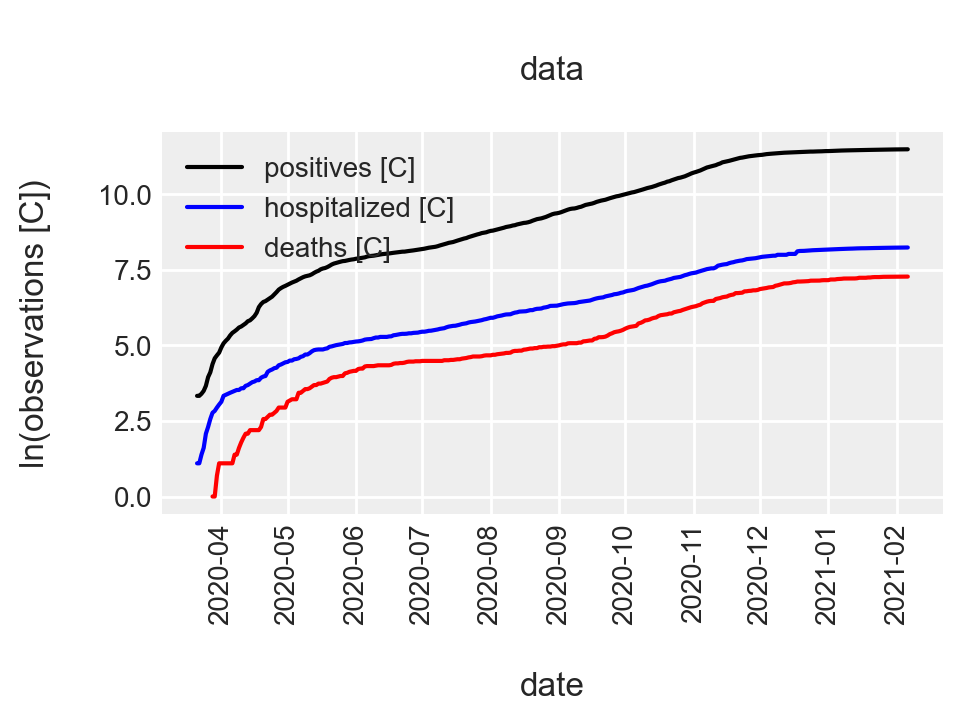

In [23]:
ax = relational.figure(width=4.7, height=3.5)
ax.set_prop_cycle(color=['black', 'blue', 'red'])

ax.plot(data.independent_, np.log(data.dependent), '-')

ax.tick_params(axis='x', labelrotation=90)
relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata\n', '\ndate', 'ln(observations [C])\n']))

ax.legend(labels=variables.label, loc='upper left', fontsize='small');                      

<br>
<br>

# Inference

## Scaled Tensors

In [24]:
import sars.models.inpatients.scaled

In [25]:
scaled = sars.models.inpatients.scaled.Scaled(data=data).exc()

logger.info('scaled\n{}\n'.format(scaled._fields))

INFO:__main__:scaled
('xscale', 'independent', 'abscissae', 'yscale', 'dependent')



<br>

## Elements

In [26]:
import sars.models.inpatients.elements

In [27]:
sections_ = scaled.independent.shape[0]
instances_ = np.ones(shape=scaled.independent.shape[0], dtype=int)

elements = sars.models.inpatients.elements.Elements(sections_=sections_, instances_=instances_).exc()

logger.info('elements\n{}\n'.format(elements._fields))

INFO:__main__:elements
('sections_', 'instances_', 'indices')



<br>
<br>

## Model

<br>

**Inference**

In [28]:
import sars.models.inpatients.natural.inference

In [29]:
inference = sars.models.inpatients.natural.inference.Inference(data=scaled, parameters=parameters, elements=elements)

<br>

Inference Model Characteristics

In [30]:
imc = inference.exc()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]
INFO:pymc3:NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1188 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1188 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6570559248741612, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.



INFO:pymc3:


In [31]:
imc._fields

('model', 'trace', 'maximal', 'arviztrace', 'likelihood')

<br>

**DAG**

* http://www.graphviz.org/doc/info/attrs.html

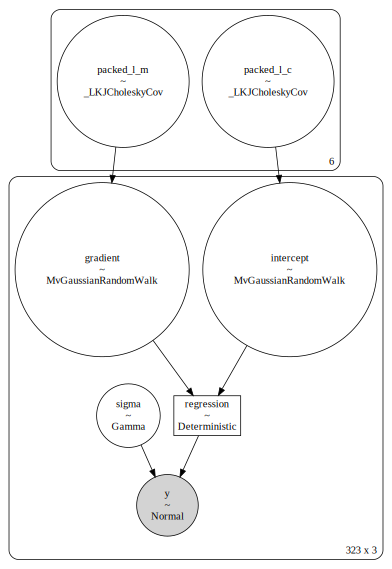

In [32]:
# The DAG
diagram = pm.model_graph.ModelGraph(model=imc.model).make_graph()
diagram.node_attr.update(shape='circle')
diagram.graph_attr.update(size="5.7,7.9")

# Diagrams
diagram.save(os.path.join(warehouse, 'model.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(warehouse, 'model.gv'))

graphviz.Source.from_file(filename=os.path.join(warehouse, 'model.gv'))

<br>

**Trace**

In [33]:
imc.trace.varnames

['packed_l_c_cholesky-cov-packed__',
 'intercept',
 'packed_l_m_cholesky-cov-packed__',
 'gradient',
 'sigma_log__',
 'packed_l_c',
 'packed_l_m',
 'regression',
 'sigma']

<br>

Samplings

In [34]:
samplings = imc.trace.report.n_draws * imc.trace.nchains
logger.info('The number of sampled instances\n{}\n'.format(samplings))

INFO:__main__:The number of sampled instances
1000



<br>
<br>

# Analysis

## Estimates

In [35]:
import sars.models.inpatients.estimates

In [36]:
estimates = sars.models.inpatients.estimates.Estimates(
    trace=imc.trace, futures=futures, samplings=samplings, parameters=parameters)

<br>

**Intercepts & Gradients**

In [37]:
Arguments = collections.namedtuple(typename='Arguments', field_names=['name', 'cholesky'])

intercepts = estimates.exc(arguments=Arguments._make(('intercept', 'packed_l_c')))
gradients = estimates.exc(arguments=Arguments._make(('gradient', 'packed_l_m')))

logger.info('\n{}\n'.format(intercepts.shape))
logger.info('\n{}\n'.format(gradients.shape))

INFO:__main__:
(1000, 344, 3)

INFO:__main__:
(1000, 344, 3)



In [38]:
InterceptsAndGradients = collections.namedtuple(typename='InterceptsAndGradients', field_names=['intercepts', 'gradients'])
iag = InterceptsAndGradients._make([intercepts, gradients])

<br>
<br>

## Predictions

In [39]:
import sars.models.inpatients.predictions

In [40]:
predictions = sars.models.inpatients.predictions.Predictions(
    iag=iag, samplings=samplings, scaled=scaled, parameters=parameters).exc(size=100)

In [41]:
logger.info('\n{}\n'.format(predictions._fields))

INFO:__main__:
('line', 'lines')



In [42]:
logger.info('\n{}\n'.format(predictions.line.shape))
logger.info('\n{}\n'.format(predictions.lines.shape))

INFO:__main__:
(344, 3)

INFO:__main__:
(100, 344, 3)



<br>
<br>

# Illustrate

In [43]:
import sars.models.inpatients.graphs

<br>

$\color{#939393}{\text{The fields}}$

Opting for **date variables**, i.e., `data.independent_ & data.abscissae_`, instead of **days thus far variables**, i.e., `data.independent & data.abscissae`, respectively.

In [44]:
Fields = collections.namedtuple(typename='Futures', field_names=['initial', 'extended'])
fields = Fields._make((data.independent_, data.abscissae_))

<br>

$\color{#939393}{\text{The labels}}$

In [45]:
variables.label

['positives [C]', 'hospitalized [C]', 'deaths [C]']

<br>

$\color{#939393}{\text{The graphing instance}}$

In [46]:
graphs = sars.models.inpatients.graphs.Graphs(data=data, predictions=predictions, titles=variables.label, fields=fields)

<br>

**Together**

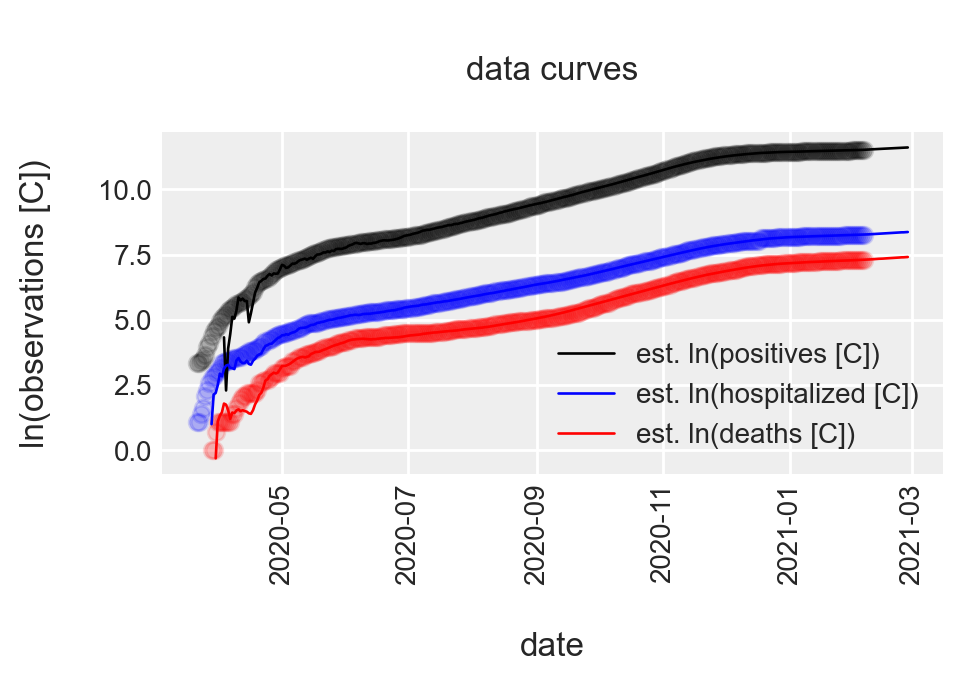

In [47]:
graphs.together(ylabel='ln(observations [C])', xlabel='date')

<br>

**Separate**

In [48]:
matplotlib.rcParams['figure.autolayout'] = False
matplotlib.rcParams['figure.constrained_layout.use'] = False
matplotlib.rcParams['figure.figsize'] = 7.1, 5.3

matplotlib.rcParams['savefig.bbox'] = 'standard'
matplotlib.rcParams["savefig.pad_inches"] = 0.5

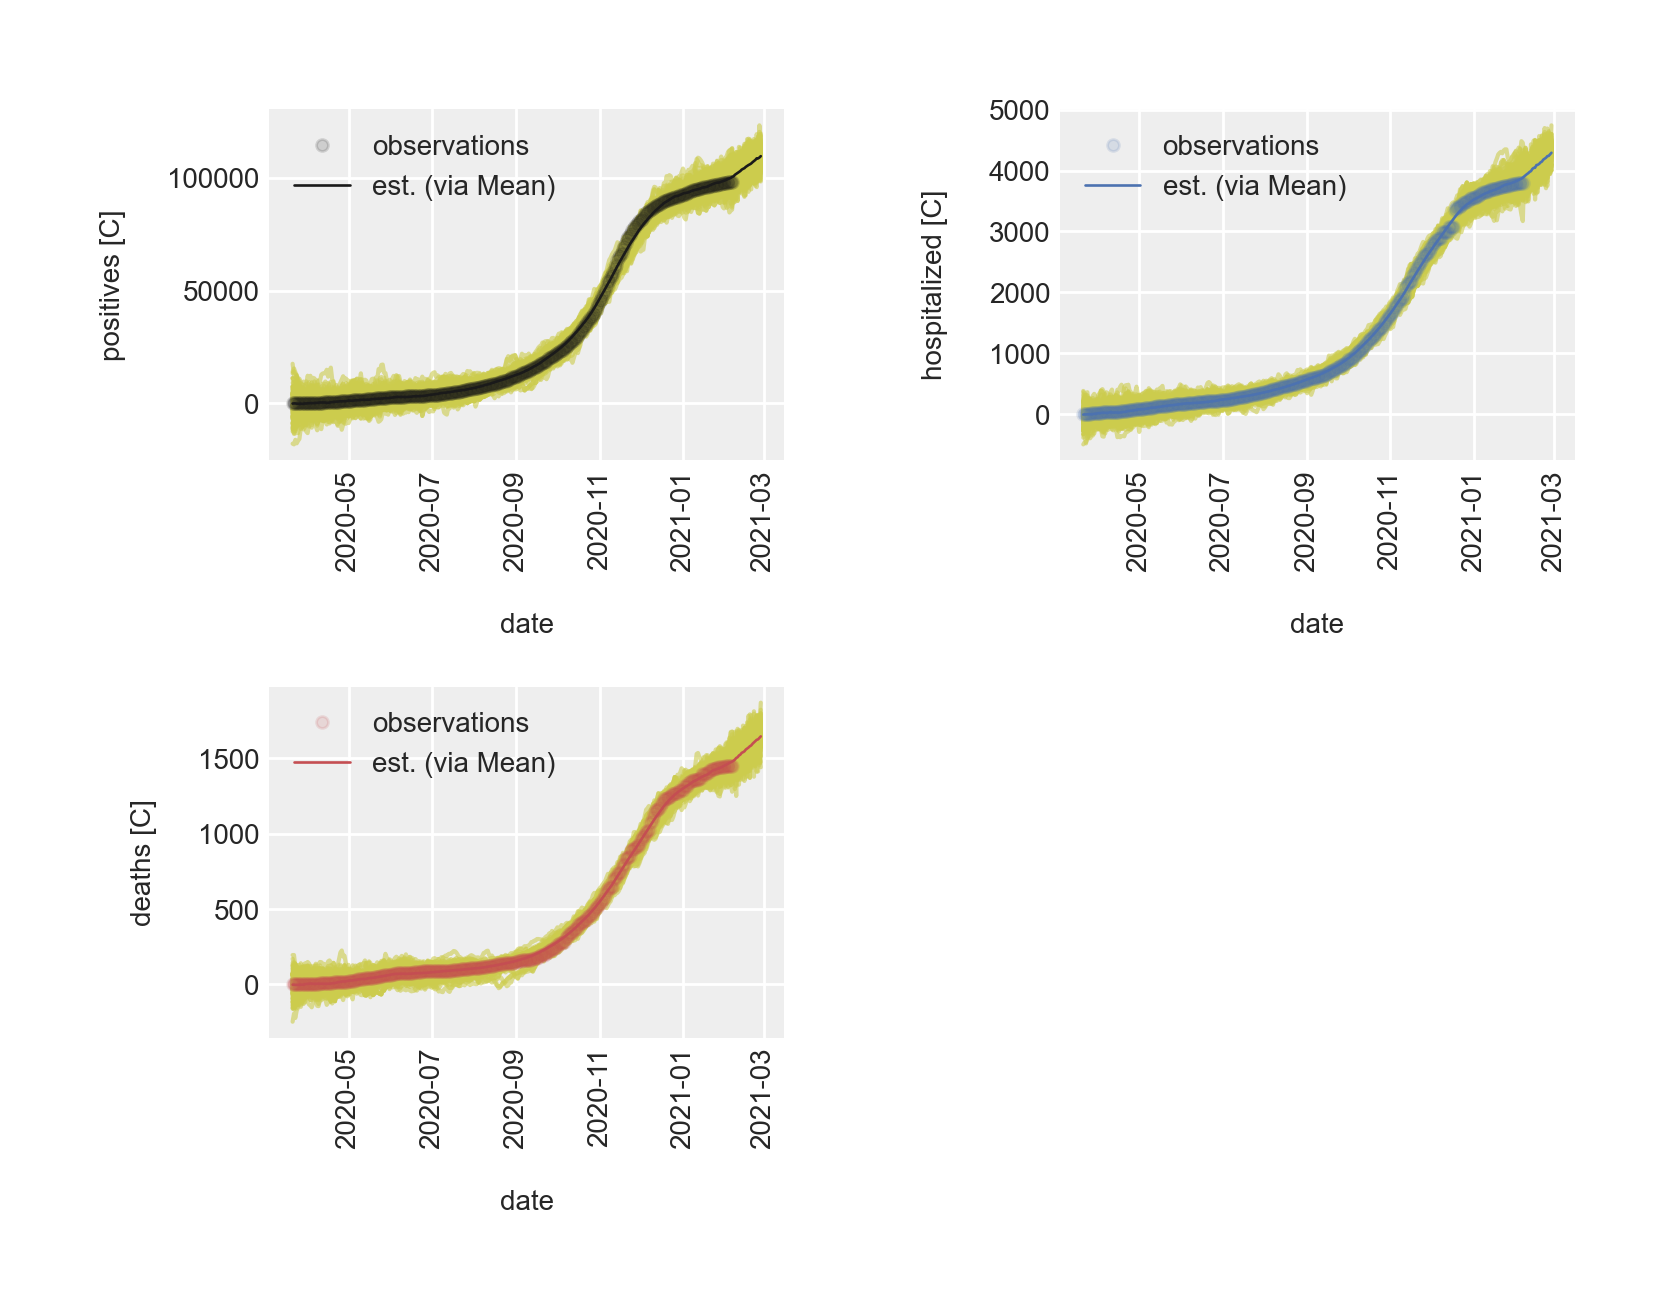

In [49]:
fig, handle = graphs.separate(adjust=np.array([5, 5]), layout=np.array([5, 7]), xlabel='date')

In [50]:
fig.savefig(os.path.join(warehouse, 'natural.png'), transparent=False, 
            pad_inches=0.25,
            bbox_inches=matplotlib.transforms.Bbox([[0, 0], [9.0, 5.5]]).expanded(sw=1.2, sh=1.0))